# Using the XApRES package
A guide to using the package XApRES to load and package together timeseries of ApRES datasets. 

## Load the package

In [ ]:
import sys
sys.path.append("/Users/jkingslake/Documents/science/ApRES/XApRES/src/XApRES/")
import ApRESDefs


## Initialize xapres 
Simply calling `apres` initializes an object which will contain our data and has methods associated with it which we will use to load and process the data.

When initalizing you have the option of setting the loggin level. This determines how detailed the logging messages will be. To make it as detailed as possible, set it to 'debug'.

In [5]:
xa = ApRESDefs.xapres(loglevel='debug')

DEBUG    16:45:05 	 ApRESDefs.py @function _setup_logging line 471 - Stream logging level set to DEBUG
DEBUG    16:45:05 	 ApRESDefs.py @function _setup_logging line 472 - Add console handler to logger
DEBUG    16:45:05 	 ApRESDefs.py @function _setup_logging line 485 - File logging level set to DEBUG


## List the dat files 
ApRES data is stored in binary files with the extension `.dat`.

The method `list_files` recursively lists all the dat files in a given directory or cloud-based file-like location. 

If you have dat files in your current directory, you can simply run `filepaths = xa.list_files()` to produce a list of the dat files.

In our case we have the dat files are in cloud storage in a google bucket. To load from a google bucket you must provide the path to the bucket as the first argument `directory` and flag that this is a remote load by defining `remote_load=True`. The following cell produces a list of all the dat files in the google bucket and prints out the first five.

In [6]:
filepaths = xa.list_files(directory='gs://ldeo-glaciology/GL_apres_2022', remote_load = True)
filepaths[0:5]

DEBUG    16:45:07 	 ApRESDefs.py @function list_files line 165 - Find all the dat files in the directory gs://ldeo-glaciology/GL_apres_2022 with remote_load = True
DEBUG    16:45:14 	 ApRESDefs.py @function list_files line 179 - Finish call to list_files. Found 386 files


['ldeo-glaciology/GL_apres_2022/A101/CardA/DIR2022-05-22-1939/DATA2022-05-22-1939.DAT',
 'ldeo-glaciology/GL_apres_2022/A101/CardA/DIR2022-05-26-1530/DATA2022-05-26-1530.DAT',
 'ldeo-glaciology/GL_apres_2022/A101/CardA/DIR2022-05-26-1536/DATA2022-05-26-1536.DAT',
 'ldeo-glaciology/GL_apres_2022/A101/CardA/DIR2022-05-26-1536/DATA2022-05-27-1506.DAT',
 'ldeo-glaciology/GL_apres_2022/A101/CardA/DIR2022-05-26-1536/DATA2022-05-28-1436.DAT']

The list of filenames is also stored as one the attributes of `xa`:

In [7]:
xa.dat_filenames[0:5]

['ldeo-glaciology/GL_apres_2022/A101/CardA/DIR2022-05-22-1939/DATA2022-05-22-1939.DAT',
 'ldeo-glaciology/GL_apres_2022/A101/CardA/DIR2022-05-26-1530/DATA2022-05-26-1530.DAT',
 'ldeo-glaciology/GL_apres_2022/A101/CardA/DIR2022-05-26-1536/DATA2022-05-26-1536.DAT',
 'ldeo-glaciology/GL_apres_2022/A101/CardA/DIR2022-05-26-1536/DATA2022-05-27-1506.DAT',
 'ldeo-glaciology/GL_apres_2022/A101/CardA/DIR2022-05-26-1536/DATA2022-05-28-1436.DAT']

## Load one of these files
The method `load_single` loads a single dat file and produces bursts and chirps from the loaded data:

In [8]:
xa.load_single(filepaths[0], remote_load=True)

DEBUG    16:45:18 	 ApRESDefs.py @function load_single line 142 - Load dat file ldeo-glaciology/GL_apres_2022/A101/CardA/DIR2022-05-22-1939/DATA2022-05-22-1939.DAT with remote_load = True
DEBUG    16:45:29 	 ApRESDefs.py @function load_single line 144 - Extract burst number 0
DEBUG    16:45:32 	 ApRESDefs.py @function load_single line 146 - Extract chirp number 0
DEBUG    16:45:32 	 ApRESDefs.py @function load_single line 148 - Form profile for chirp number 0
DEBUG    16:45:32 	 ApRESDefs.py @function load_single line 150 - Finish call to load_single.


You can now load the results from `xa` and either plot them yourself using matplotlib or similar, or use a build in plotting function `PlotProfile` for a quick look:

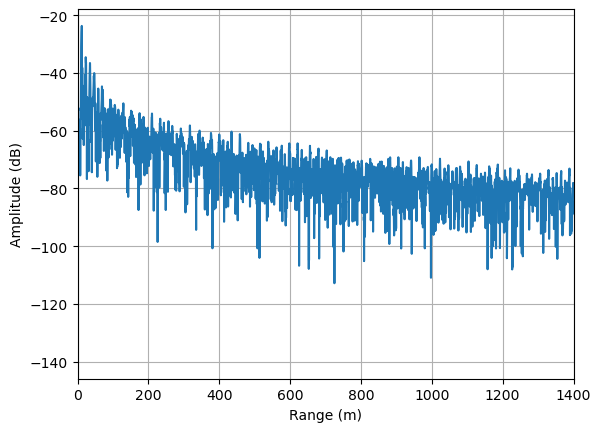

In [9]:
xa.single_profile.PlotProfile(1400);

## Put multiple bursts in an xarray

This is the main purpose od XApRES. We want to loop through all our dat files, and loop through all the bursts in each dat file, and compute the profile for each one and store it all in a convenient way. 

The method `load_all` performs these loops. In general we would like to loop over all bursts and dat files, but for this demonstration let's just process two dat files and two bursts from each dat file. `load_all` takes two optional arguments `file_numbers_to_process` and `bursts_to_process`, which are lists of the dat files and burst to process:

In [3]:
%%time 
import importlib
importlib.reload(ApRESDefs)  
xa = ApRESDefs.xapres(loglevel='debug', max_range=1400)
xa.load_all(directory='gs://ldeo-glaciology/GL_apres_2022', 
            remote_load = True,
            file_numbers_to_process = [0, 1], 
            bursts_to_process=[0, 1]
           )
xa.data

DEBUG    21:51:50 	 ApRESDefs.py @function _setup_logging line 471 - Stream logging level set to DEBUG
DEBUG    21:51:50 	 ApRESDefs.py @function _setup_logging line 472 - Add console handler to logger
DEBUG    21:51:50 	 ApRESDefs.py @function _setup_logging line 485 - File logging level set to DEBUG
DEBUG    21:51:50 	 ApRESDefs.py @function list_files line 164 - Find all the dat files in the directory gs://ldeo-glaciology/GL_apres_2022 with remote_load = True
DEBUG    21:51:56 	 ApRESDefs.py @function list_files line 178 - Finish call to list_files. Found 386 files
DEBUG    21:51:56 	 ApRESDefs.py @function load_all line 197 - Subset files to [0, 1]
DEBUG    21:51:56 	 ApRESDefs.py @function load_all line 206 - Starting loop over dat files


0it [00:00, ?it/s]

DEBUG    21:51:56 	 ApRESDefs.py @function load_all line 209 - Load dat file number 0, ldeo-glaciology/GL_apres_2022/A101/CardA/DIR2022-05-22-1939/DATA2022-05-22-1939.DAT
DEBUG    21:52:00 	 ApRESDefs.py @function _all_bursts_in_dat_to_xarray line 236 - This dat file has 13 bursts.
DEBUG    21:52:00 	 ApRESDefs.py @function _all_bursts_in_dat_to_xarray line 237 - bursts_to_process = [0, 1] at the start of _all_bursts_in_dat_to_xarray.
DEBUG    21:52:00 	 ApRESDefs.py @function _all_bursts_in_dat_to_xarray line 250 - bursts_to_process = [0, 1] after initial parse in _all_bursts_in_dat_to_xarray.
DEBUG    21:52:00 	 ApRESDefs.py @function _all_bursts_in_dat_to_xarray line 252 - Start loop over burst numbers [0, 1] in dat file ldeo-glaciology/GL_apres_2022/A101/CardA/DIR2022-05-22-1939/DATA2022-05-22-1939.DAT



  0%|                                                     | 0/2 [00:00<?, ?it/s]

DEBUG    21:52:00 	 ApRESDefs.py @function _all_bursts_in_dat_to_xarray line 257 - Extract burst number 0
DEBUG    21:52:02 	 ApRESDefs.py @function _burst_to_xarray line 273 - Put all chirps and profiles from burst number 0 in 3D arrays
DEBUG    21:52:02 	 ApRESDefs.py @function _burst_to_3d_arrays line 326 - Set max range from _burst_to_3d_arrays
DEBUG    21:52:02 	 ApRESDefs.py @function _set_max_range line 382 - Max_range has been set to 1400
DEBUG    21:52:04 	 ApRESDefs.py @function _coords_from_burst line 361 - Set max range from _coords_from_burst
DEBUG    21:52:04 	 ApRESDefs.py @function _set_max_range line 382 - Max_range has been set to 1400



 50%|██████████████████████▌                      | 1/2 [00:04<00:04,  4.19s/it]

DEBUG    21:52:04 	 ApRESDefs.py @function _all_bursts_in_dat_to_xarray line 257 - Extract burst number 1
DEBUG    21:52:06 	 ApRESDefs.py @function _burst_to_xarray line 273 - Put all chirps and profiles from burst number 1 in 3D arrays
DEBUG    21:52:06 	 ApRESDefs.py @function _burst_to_3d_arrays line 326 - Set max range from _burst_to_3d_arrays
DEBUG    21:52:06 	 ApRESDefs.py @function _set_max_range line 382 - Max_range has been set to 1400
DEBUG    21:52:08 	 ApRESDefs.py @function _coords_from_burst line 361 - Set max range from _coords_from_burst
DEBUG    21:52:08 	 ApRESDefs.py @function _set_max_range line 382 - Max_range has been set to 1400



100%|█████████████████████████████████████████████| 2/2 [00:07<00:00,  3.81s/it]

DEBUG    21:52:08 	 ApRESDefs.py @function _all_bursts_in_dat_to_xarray line 263 - Concatenating all the single-burst xarrays from dat file ldeo-glaciology/GL_apres_2022/A101/CardA/DIR2022-05-22-1939/DATA2022-05-22-1939.DAT
DEBUG    21:52:08 	 ApRESDefs.py @function load_all line 216 - Finished processing file number 0, ldeo-glaciology/GL_apres_2022/A101/CardA/DIR2022-05-22-1939/DATA2022-05-22-1939.DAT



1it [00:11, 11.86s/it]

DEBUG    21:52:08 	 ApRESDefs.py @function load_all line 209 - Load dat file number 1, ldeo-glaciology/GL_apres_2022/A101/CardA/DIR2022-05-26-1530/DATA2022-05-26-1530.DAT
DEBUG    21:52:08 	 ApRESDefs.py @function _all_bursts_in_dat_to_xarray line 236 - This dat file has 1 bursts.
DEBUG    21:52:08 	 ApRESDefs.py @function _all_bursts_in_dat_to_xarray line 237 - bursts_to_process = [0, 1] at the start of _all_bursts_in_dat_to_xarray.
DEBUG    21:52:08 	 ApRESDefs.py @function _all_bursts_in_dat_to_xarray line 246 - The burst numbers requested in bursts_to_process ([0, 1]) is greater than the number of bursts in                the dat file (1), so we will just process all the bursts.
DEBUG    21:52:08 	 ApRESDefs.py @function _all_bursts_in_dat_to_xarray line 250 - bursts_to_process = [0] after initial parse in _all_bursts_in_dat_to_xarray.
DEBUG    21:52:08 	 ApRESDefs.py @function _all_bursts_in_dat_to_xarray line 252 - Start loop over burst numbers [0] in dat file ldeo-glaciology/GL_


  0%|                                                     | 0/1 [00:00<?, ?it/s]

DEBUG    21:52:08 	 ApRESDefs.py @function _all_bursts_in_dat_to_xarray line 257 - Extract burst number 0
DEBUG    21:52:09 	 ApRESDefs.py @function _burst_to_xarray line 273 - Put all chirps and profiles from burst number 0 in 3D arrays
DEBUG    21:52:09 	 ApRESDefs.py @function _burst_to_3d_arrays line 326 - Set max range from _burst_to_3d_arrays
DEBUG    21:52:09 	 ApRESDefs.py @function _set_max_range line 382 - Max_range has been set to 1400
DEBUG    21:52:11 	 ApRESDefs.py @function _coords_from_burst line 361 - Set max range from _coords_from_burst
DEBUG    21:52:11 	 ApRESDefs.py @function _set_max_range line 382 - Max_range has been set to 1400



100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.43s/it]

DEBUG    21:52:11 	 ApRESDefs.py @function _all_bursts_in_dat_to_xarray line 263 - Concatenating all the single-burst xarrays from dat file ldeo-glaciology/GL_apres_2022/A101/CardA/DIR2022-05-26-1530/DATA2022-05-26-1530.DAT
DEBUG    21:52:11 	 ApRESDefs.py @function load_all line 216 - Finished processing file number 1, ldeo-glaciology/GL_apres_2022/A101/CardA/DIR2022-05-26-1530/DATA2022-05-26-1530.DAT



2it [00:14,  7.43s/it]

DEBUG    21:52:11 	 ApRESDefs.py @function load_all line 217 - Concatenating all the multi-burst xarrays to create xapres.data
DEBUG    21:52:11 	 ApRESDefs.py @function _add_attrs line 386 - Adding attributes to the xapres.data
DEBUG    21:52:11 	 ApRESDefs.py @function load_all line 223 - Finish call to load_all. Call xapres.data to see the xarray this produced.
CPU times: user 5.7 s, sys: 1.22 s, total: 6.91 s
Wall time: 21.4 s


<xarray.Dataset>
Dimensions:          (time: 3, chirp_time: 40001, chirp_num: 20,
                      attenuator_setting_pair: 2, profile_range: 6658)
Coordinates:
  * time             (time) datetime64[ns] 2022-05-22T19:40:20 ... 2022-05-26...
  * chirp_time       (chirp_time) float64 0.0 2.5e-05 5e-05 ... 1.0 1.0 1.0
  * profile_range    (profile_range) float64 0.0 0.2103 ... 1.4e+03 1.4e+03
  * chirp_num        (chirp_num) int64 0 1 2 3 4 5 6 7 ... 13 14 15 16 17 18 19
    filename         (time) <U83 'ldeo-glaciology/GL_apres_2022/A101/CardA/DI...
    burst_number     (time) int64 0 1 0
    AFGain           (time, attenuator_setting_pair) int64 -14 -14 ... -4 -14
    attenuator       (time, attenuator_setting_pair) float64 10.0 20.0 ... 5.0
Dimensions without coordinates: attenuator_setting_pair
Data variables:
    chirp            (time, chirp_time, chirp_num, attenuator_setting_pair) float64 ...
    profile          (time, profile_range, chirp_num, attenuator_setting_pair) complex128 ...
    latitude         (time) float64 69.22 69.22 68.71
    longitude        (time) float64 -51.12 -51.12 -49.55
    battery_voltage  (time) float64 12.33 12.48 13.93
    temperature_1    (time) float64 4.383 7.32 2.812
    temperature_2    (time) float64 5.195 1.469 2.25
Attributes:
    time created:  2022-11-14 21:52:11.388941

The xarray only contains three bursts (`len(xa.data.time) = 3`) because, although we asked for bursts 0 and 1 from each file, the second file only had one burst in it. `_all_bursts_in_dat_to_xarray` catches this issue when it comes up and only tries to load bursts that exist in each dat file. 

## Plotting 
We can use xarray's plotting tools to take a look at the data. 

A simple start is to plot all the chirp voltages as a histogram

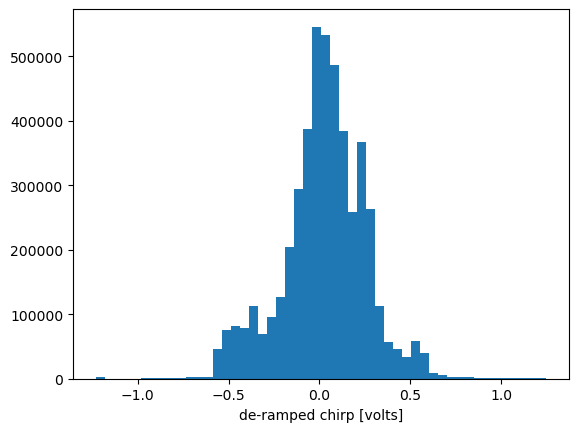

In [12]:
xa.data.chirp.plot(bins = 50);

Next we can plot individual chirps, for example,

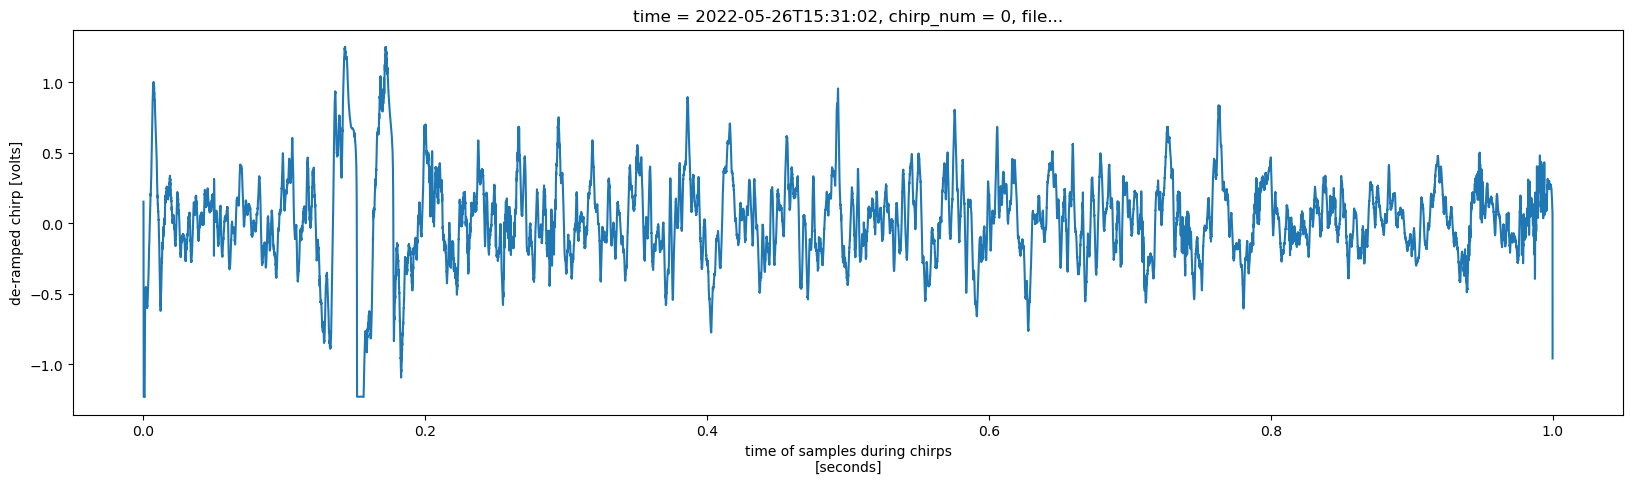

In [13]:
xa.data.chirp.isel(time=2, chirp_num = 0, attenuator_setting_pair=0).plot(figsize = (20,5));

or stack all the chirps in a particular burst and plot them:

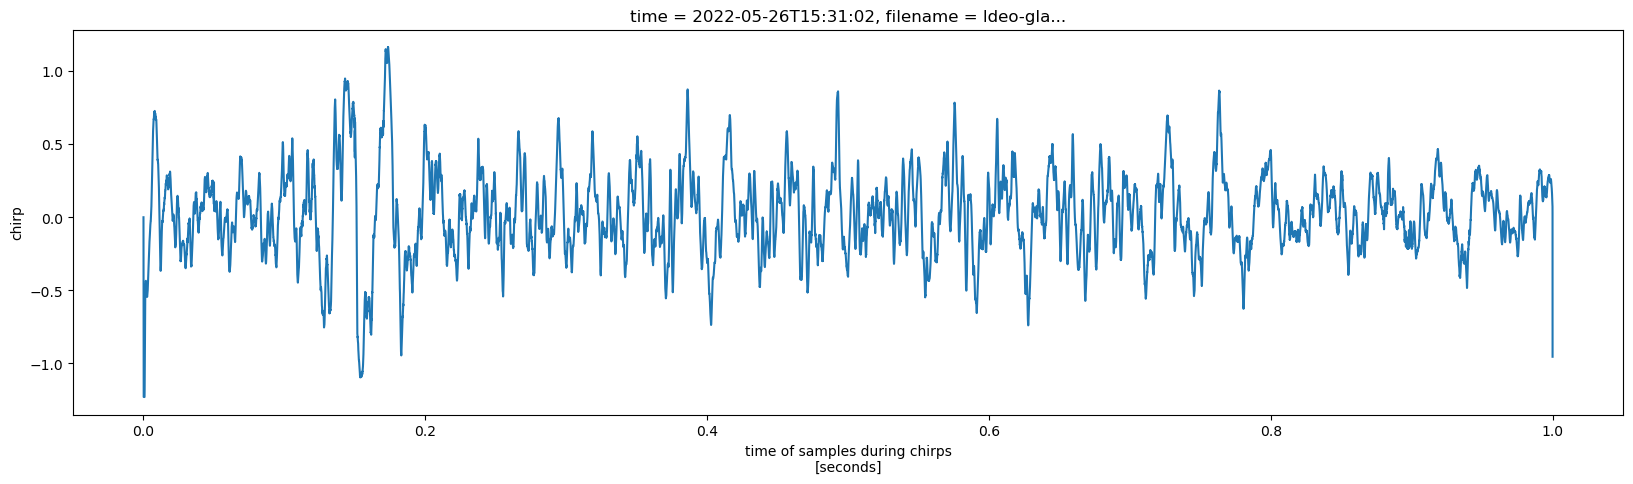

In [14]:
xa.data.chirp.isel(time=2,attenuator_setting_pair=0).mean(dim='chirp_num').plot(figsize = (20,5));

If we want to plot the amplitude profile, we can use the method `ApRESDefs.xapres.dB`. It is converts the complex profiles stored in xa.data.profile into decibels:

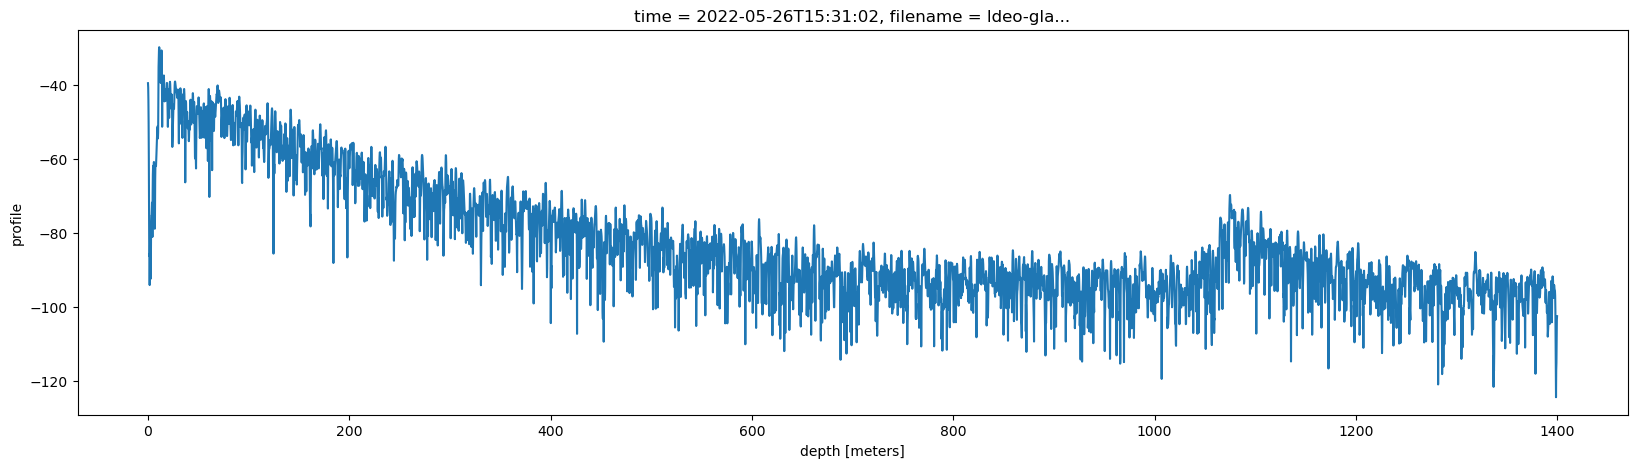

In [11]:
# stack the data (this line stacks both the chirps and the profiles, but you could just do the profiles)
stacked = xa.data.isel(time=2, attenuator_setting_pair=0).mean(dim='chirp_num')
# extract just the profiles
stacked_profile = stacked.profile
# compute the decibel profiles
dB = xa.dB(stacked_profile)
# plot the result
dB.plot(figsize = (20,5));

Note that you could do all four commands above in one go using one of the two following methods:

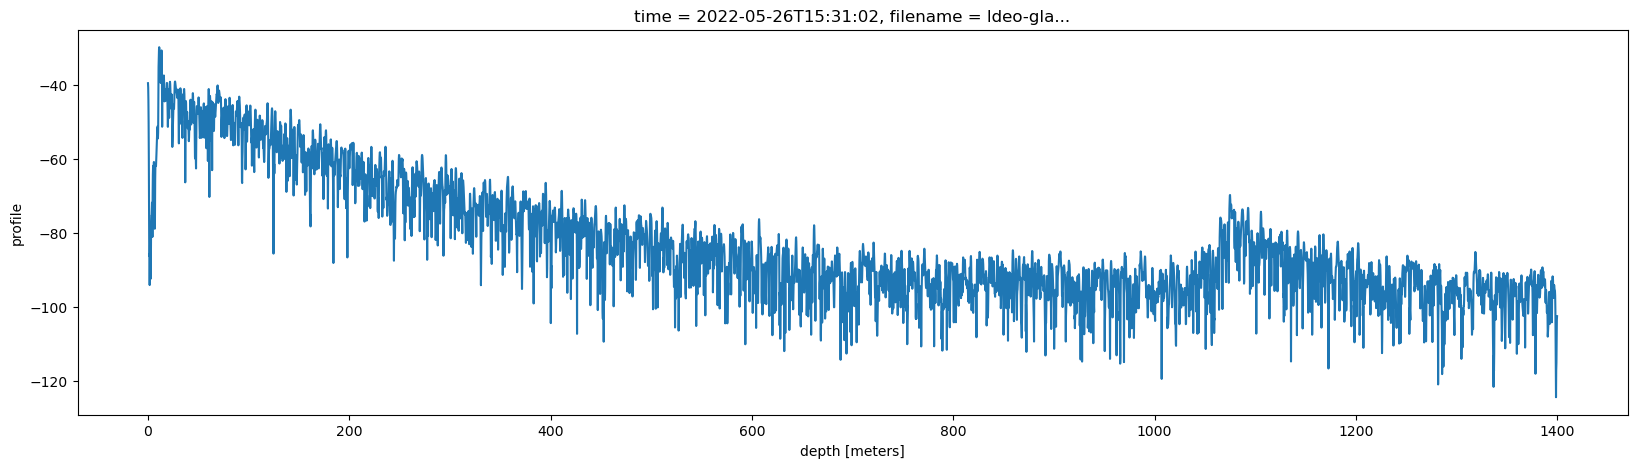

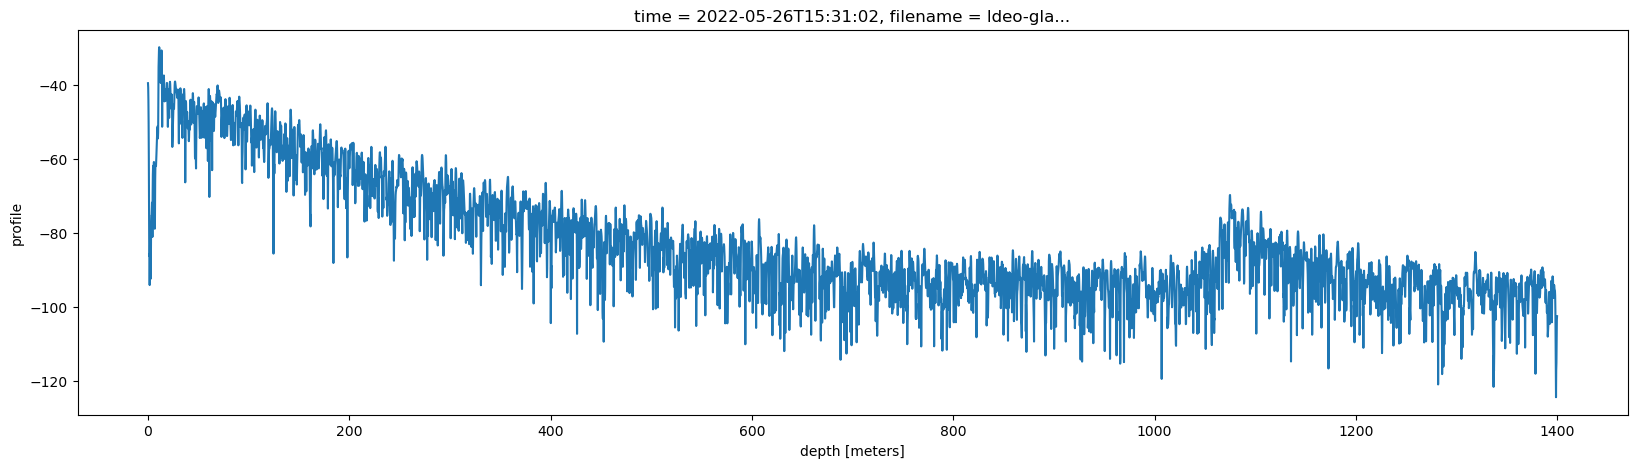

In [17]:
xa.dB(xa.data.isel(time=2, attenuator_setting_pair=0).mean(dim='chirp_num')).profile.plot(figsize = (20,5));
# or
xa.dB(xa.data.profile.isel(time=2, attenuator_setting_pair=0).mean(dim='chirp_num')).plot(figsize = (20,5));